### Load things to work with data and initial trained model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/AML/AML_course/Project

/content/drive/MyDrive/AML/AML_course/Project


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.io
import json
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
import numpy as np
from modules.data_preprocessing import data_reallocation, create_datasets
from modules.train_classfier import train, test_eval
from modules.generate_images import generate_from_prompt


In [4]:
%cd /content

/content


In [5]:
import gdown
url = "https://drive.google.com/drive/folders/1c2xufL1sNJHbQ3v3b5l1jmYx86ahDgLQ"

gdown.download_folder(url, output='flower102')

Retrieving folder contents


Processing file 1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID 102flowers.tgz
Processing file 1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL cat_to_name.json
Processing file 1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn imagelabels.mat
Processing file 1m8mSQlD27WR2vHp-PkiQ_17ts408xn10 setid.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID
From (redirected): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID&confirm=t&uuid=3b4ea075-f9b5-445b-bb48-e3e3e3c49882
To: /content/flower102/102flowers.tgz
100%|██████████| 345M/345M [00:02<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL
To: /content/flower102/cat_to_name.json
100%|██████████| 2.22k/2.22k [00:00<00:00, 5.25MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn
From (redirected): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn&confirm=t&uuid=4efcc29b-cd71-4573-948c-70203ab3ccf0
To: /content/flower102/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 386kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1m8mSQlD27WR

['flower102/102flowers.tgz',
 'flower102/cat_to_name.json',
 'flower102/imagelabels.mat',
 'flower102/setid.mat']

In [6]:
import tarfile
source_path = "flower102/102flowers.tgz"
destination_path = "flower102"

with tarfile.open(source_path, "r:gz") as tar:
      tar.extractall(path=destination_path)

os.remove(source_path)

In [7]:
# Define paths
data_path = 'flower102'
images_path = os.path.join(data_path, 'jpg')
output_path = 'data'

data_reallocation(data_path,
                  images_path,
                  output_path)

Images reallocated successfully to folder data


In [8]:
train_dataset, val_dataset, test_dataset = create_datasets(output_path, batch_size=32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

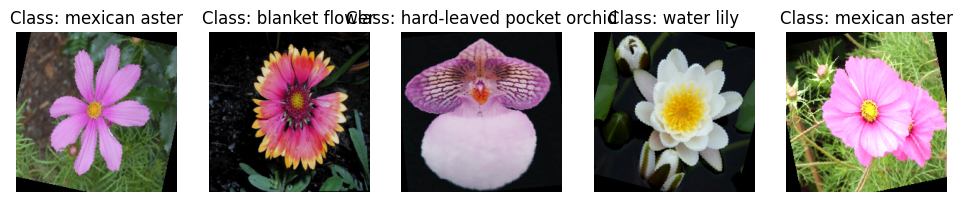

In [9]:
# plot 4 images from data
swapped_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax in axes:
    picture_number = random.randint(0, len(train_dataset))
    image = train_dataset[picture_number][0].permute(1, 2, 0)
    #unnormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    ax.imshow(image)
    ax.set_title(f"Class: {swapped_dict[train_dataset[picture_number][1]]}")
    ax.axis('off')

In [10]:
#saved model
from torchvision import models
file_id = '1-m3nC5im8MtNBaajab8OTm7I33voeVsi'
output = 'model.pth'
gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-m3nC5im8MtNBaajab8OTm7I33voeVsi
From (redirected): https://drive.google.com/uc?id=1-m3nC5im8MtNBaajab8OTm7I33voeVsi&confirm=t&uuid=a06ed078-1f2b-497a-a11e-abf40496ec1a
To: /content/model.pth
100%|██████████| 95.2M/95.2M [00:02<00:00, 32.0MB/s]


'model.pth'

In [11]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 102) # 102 is the number of classes in flower102
model.load_state_dict(torch.load(output))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-11-ee3120f96e31>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Metrics and worst classes

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


In [31]:
cm = confusion_matrix(all_labels, all_preds)
class_f1 = []
class_precision = []
class_recall = []
num_classes = cm.shape[0]
num_confused_classes = []

for i in range(num_classes):
  precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:,i]) > 0 else 0
  recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i,:]) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  print(f"Class: {swapped_dict[i]}, F1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
  class_f1.append(f1)
  class_precision.append(precision)
  class_recall.append(recall)
  confused_classes = np.where(cm[i, :] > 0)[0]  # All classes where there are non-zero predictions
  confused_classes = confused_classes[confused_classes != i]  # Exclude the correct class
  num_confused_classes.append(len(confused_classes))
  print(f"Confused with classes: {confused_classes}")


Class: alpine sea holly, F1: 0.9524, precision: 0.9091, recall: 1.0000
Confused with classes: []
Class: anthurium, F1: 0.7059, precision: 0.8571, recall: 0.6000
Confused with classes: [19 20 95]
Class: artichoke, F1: 0.8889, precision: 1.0000, recall: 0.8000
Confused with classes: [51]
Class: azalea, F1: 0.1818, precision: 1.0000, recall: 0.1000
Confused with classes: [20 22 48 71 87 91]
Class: ball moss, F1: 0.7273, precision: 0.6667, recall: 0.8000
Confused with classes: [23 40]
Class: balloon flower, F1: 0.5517, precision: 0.4211, recall: 0.8000
Confused with classes: [71 84]
Class: barbeton daisy, F1: 0.6667, precision: 1.0000, recall: 0.5000
Confused with classes: [23 40 86]
Class: bearded iris, F1: 0.5714, precision: 0.5455, recall: 0.6000
Confused with classes: [ 31  85  87 101]
Class: bee balm, F1: 0.7778, precision: 0.8750, recall: 0.7000
Confused with classes: [51 54 76]
Class: bird of paradise, F1: 1.0000, precision: 1.0000, recall: 1.0000
Confused with classes: []
Class: bi

In [48]:
worst_classes_indices = np.argsort(num_confused_classes)[:-20:-1]

print("20 Classes with most confusions:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} -  num_confused_classes: {num_confused_classes[i]}, F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

20 Classes with most confusions:
Class: mexican petunia, 59 -  num_confused_classes: 8, F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: snapdragon, 82 -  num_confused_classes: 7, F1: 0.4286, precision: 0.7500, recall: 0.3000
Class: lenten rose, 52 -  num_confused_classes: 7, F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: columbine, 27 -  num_confused_classes: 7, F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: clematis, 25 -  num_confused_classes: 6, F1: 0.3333, precision: 1.0000, recall: 0.2000
Class: japanese anemone, 50 -  num_confused_classes: 6, F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: canna lily, 20 -  num_confused_classes: 6, F1: 0.3636, precision: 0.3333, recall: 0.4000
Class: azalea, 3 -  num_confused_classes: 6, F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: ruby-lipped cattleya, 79 -  num_confused_classes: 5, F1: 0.4000, precision: 0.6000, recall: 0.3000
Class: lotus lotus, 53 -  num_confused_classes: 5, F1: 0.6250, precision: 0.8333, recall:

In [20]:
worst_classes_indices = np.argsort(class_recall)[:20]

print("10 Classes with worst validation F1:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

10 Classes with worst validation F1:
Class: monkshood, 60 F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: mexican petunia, 59 F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: azalea, 3 F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: clematis, 25 F1: 0.3333, precision: 1.0000, recall: 0.2000
Class: lenten rose, 52 F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: japanese anemone, 50 F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: ruby-lipped cattleya, 79 F1: 0.4000, precision: 0.6000, recall: 0.3000
Class: columbine, 27 F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: snapdragon, 82 F1: 0.4286, precision: 0.7500, recall: 0.3000
Class: sword lily, 89 F1: 0.5714, precision: 1.0000, recall: 0.4000
Class: cyclamen, 30 F1: 0.5714, precision: 1.0000, recall: 0.4000
Class: canna lily, 20 F1: 0.3636, precision: 0.3333, recall: 0.4000
Class: barbeton daisy, 6 F1: 0.6667, precision: 1.0000, recall: 0.5000
Class: canterbury bells, 21 F1: 0.5882, precision: 0.7143, recall

In [15]:
print('Ok')

Ok


In [25]:
worst_classes_indices = np.argsort(class_f1)[:20]

print("10 Classes with worst validation F1:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} - F1: {class_f1[i]:.4f}, precision: {class_precision[i]:.4f}, recall: {class_recall[i]:.4f}")

10 Classes with worst validation F1:
Class: azalea, 3 - F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: monkshood, 60 - F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: mexican petunia, 59 - F1: 0.1818, precision: 1.0000, recall: 0.1000
Class: clematis, 25 - F1: 0.3333, precision: 1.0000, recall: 0.2000
Class: canna lily, 20 - F1: 0.3636, precision: 0.3333, recall: 0.4000
Class: sweet pea, 87 - F1: 0.3846, precision: 0.3125, recall: 0.5000
Class: ruby-lipped cattleya, 79 - F1: 0.4000, precision: 0.6000, recall: 0.3000
Class: snapdragon, 82 - F1: 0.4286, precision: 0.7500, recall: 0.3000
Class: japanese anemone, 50 - F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: lenten rose, 52 - F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: columbine, 27 - F1: 0.4615, precision: 1.0000, recall: 0.3000
Class: camellia, 19 - F1: 0.5000, precision: 0.3889, recall: 0.7000
Class: hibiscus, 48 - F1: 0.5517, precision: 0.4211, recall: 0.8000
Class: balloon flower, 5 - F1: 0.5517, precis

### Generation

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [23]:
# Import necessary libraries
from diffusers import StableDiffusionPipeline
import torch

# Load the pretrained Stable Diffusion model from Hugging Face
model_id = "stabilityai/stable-diffusion-2" # Replace with the desired model ID
device = "cuda" if torch.cuda.is_available() else "cpu"

# # Initialize the pipeline
# pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device == "cuda" else torch.float32)
# pipeline.to(device)




sword lily is not known concept - it knows only gladioulus

cattaleya - average

lenten rose - average (google cannot recognise some of them)

flower prince of wales feathers - only can generate things by official name (Amaranthus hypochondriacus) - not always plausible as well

In [49]:
worst_class = 52
output_dir = 'raw_model_examples_' + 'Amaranthus hypochondriacus'
os.makedirs(output_dir, exist_ok=True)

generate_from_prompt(model_id = model_id,
                     prompt = f"A photo of a {'Amaranthus hypochondriacus'}",
                     device = device,
                     output_dir = output_dir,
                     num_images = 3)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_Amaranthus hypochondriacus/a_photo_of_a_amaranthus_hypochondriacus_0.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_Amaranthus hypochondriacus/a_photo_of_a_amaranthus_hypochondriacus_1.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples_Amaranthus hypochondriacus/a_photo_of_a_amaranthus_hypochondriacus_2.png


In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Normalize

transform = Resize((299, 299))
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = ToTensor()(image)
    tensor = transform(tensor)
    tensor = normalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

In [ ]:
!pip install torcheval
from torcheval import metrics
fid_metric = metrics.FrechetInceptionDistance(device = device)

In [ ]:
path_to_real_images = os.path.join('data/val', swapped_dict[worst_class])
path_to_real_images_train = os.path.join('data/train', swapped_dict[worst_class])

fake_images = torch.stack([preprocess_image(os.path.join(output_dir, filename)) for filename in os.listdir(output_dir)])
real_images = torch.stack([preprocess_image(os.path.join(path_to_real_images, filename)) for filename in os.listdir(path_to_real_images)])
real_images_train = torch.stack([preprocess_image(os.path.join(path_to_real_images_train, filename)) for filename in os.listdir(path_to_real_images_train)])

fid_metric.update(real_images, is_real=True)
# fid_metric.update(real_images_train, is_real=True)
fid_metric.update(fake_images, is_real=False)

In [ ]:
fid_metric.compute()

In [ ]:

num_images_to_display = min(len(os.listdir(output_dir)), len(os.listdir(path_to_real_images)))
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

# Display real images
for i, filename in enumerate(os.listdir(path_to_real_images)[:num_images_to_display]):
    image_path = os.path.join(path_to_real_images, filename)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Real {i+1}")
    axes[0, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(output_dir)[:num_images_to_display]):
    image_path = os.path.join(output_dir, filename)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Generated {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()